In [1]:
# Biblioteca de importação
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()
sns.set(rc={'figure.figsize':(15,6)})
%matplotlib inline
from sympy.plotting import plot
from sympy import *
#from math import exp
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
#from numpy import log
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.arima_model import ARMAResults
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import warnings


In [4]:
#! pip install pmdarima==1.8.2

In [2]:
# Verifica a pasta corrente
pasta = os.getcwd()

In [3]:
pasta_resultados = os.path.join(pasta, "resultados")

In [4]:
# Regex notation by "\s+". This means a single space, or multiple spaces are all to be treated as a single separator.
# df_dados = pd.read_csv('bltper_1x1.txt', skiprows=2, sep = '\s+')
df_dados = pd.read_csv(os.path.join(pasta, "dados") + "/" + 'bltper_1x1.txt', skiprows=2, sep = '\s+') 

In [5]:
df_dados.head().append(df_dados.tail())

,Year,Age,mx,qx,ax,lx,dx,Lx,Tx,ex
0,1933,0,0.06129,0.05861,0.25,100000,5861,95624,6089609,60.90
1,1933,1,0.00946,0.00941,0.50,94139,886,93696,5993985,63.67
2,1933,2,0.00435,0.00434,0.50,93253,405,93050,5900289,63.27
3,1933,3,0.00310,0.00310,0.50,92848,288,92704,5807239,62.55
4,1933,4,0.00239,0.00238,0.50,92560,221,92450,5714535,61.74
9652,2019,106,0.51164,0.40742,0.50,272,111,216,497,1.83
9653,2019,107,0.54239,0.42668,0.50,161,69,127,281,1.75
9654,2019,108,0.57289,0.44533,0.50,92,41,72,154,1.67
9655,2019,109,0.60292,0.46327,0.50,51,24,39,83,1.62
9656,2019,110+,0.63226,1.00000,1.58,27,27,43,43,1.58


In [6]:
# Tratamento da idade 110+ para os anos.
# DataFrame.loc[condition, column_name] = new_value
df_dados.loc[(df_dados.Age == '110+'),'Age'] = 110
# Aproveitar e corrigir a tipagem da feature Age
df_dados["Age"] = df_dados["Age"].astype(int) 

In [7]:
df_dados.head().append(df_dados.tail())

,Year,Age,mx,qx,ax,lx,dx,Lx,Tx,ex
0,1933,0,0.06129,0.05861,0.25,100000,5861,95624,6089609,60.90
1,1933,1,0.00946,0.00941,0.50,94139,886,93696,5993985,63.67
2,1933,2,0.00435,0.00434,0.50,93253,405,93050,5900289,63.27
3,1933,3,0.00310,0.00310,0.50,92848,288,92704,5807239,62.55
4,1933,4,0.00239,0.00238,0.50,92560,221,92450,5714535,61.74
9652,2019,106,0.51164,0.40742,0.50,272,111,216,497,1.83
9653,2019,107,0.54239,0.42668,0.50,161,69,127,281,1.75
9654,2019,108,0.57289,0.44533,0.50,92,41,72,154,1.67
9655,2019,109,0.60292,0.46327,0.50,51,24,39,83,1.62
9656,2019,110,0.63226,1.00000,1.58,27,27,43,43,1.58


> ##### Obs.: Poderíamos utilizar $ q_x $ (probabilidade de morte) no lugar de $ m_{x,t} $ (Taxa central de mortalidade), pois o resultado é muito próximo, conforme podemos ver no gráfico abaixo, porém como a implementação não é complexa e para manter o mesmo conceito, constante no artigo supracitado. 

$ q_{x,t} $ em função de $ m_{x,t} $: 
* $ q_{x,t} = \frac{m_{x,t}}{(1-0.5*m_{x,t})} \approx m_{x,t} $ 
* $ q_{x,t} = 1 - e^{-m_{x,t}} \approx m_{x,t} $

#### Passo 1 — Preparação da base para o método Lee-Carter

##### 1.1 - Gráfico comparativo entre qx (probabilidade de morte) e mx(taxa central de mortalidade)

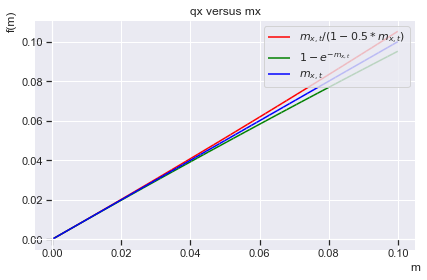

In [8]:
m=Symbol('m')
# teste:plot(expr, range, kwargs)
# teste:plot(x**2, line_color='red')
# teste:plot(sin(x),cos(x), (x, -pi, pi))
# m/(1-0.5*m)
# 1-exp(1)^m
# m
p = plot(m/(1-0.5*m), 1-exp(1)**(-m), m, (m, 0, 0.1), legend=True, title = 'qx versus mx', show=False) # Se retirar o show=False, o gráfico se repete
p[0].line_color = 'red'
p[1].line_color = 'green'
p[2].line_color = 'blue'
p[0].label = '$ {m_{x,t}}/{(1-0.5*m_{x,t})} $'
p[1].label = '$ 1-e^{-m_{x,t}} $'
p[2].label = '$ m_{x,t} $'
#plt.legend(loc='lower right')
p.save(pasta_resultados + '/' + 'qx_versus_mx.png')
p.show()
# plt.savefig('test.png')

##### 1.2 - Feature, denominada mx, Taxa Central de Mortalidade, para comparar se existe diferença substancial dos parâmetros zx, bx, kt, utilizados no modelo Lee-Carter
$ m_x = \frac{dx}{Lx} $

##### 1.3 - Visualização  $ l_x, q_x $ e $ log(m_x) $ dos anos 2000, 2010 e 2018 (amostra)

In [9]:
# Gráfico de m{x,t}. Amostral
#df_dados["Age"] = df_dados["Age"].astype(int) 
df_dados2018 = df_dados.query("Year == 2018")
df_dados2010 = df_dados.query("Year == 2010")
df_dados2000 = df_dados.query("Year == 2000")

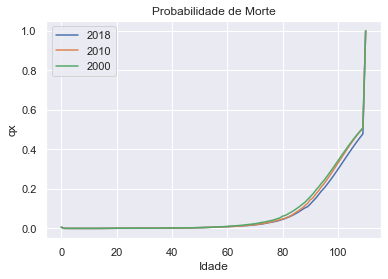

In [10]:
#df_dadosx_0['ano'] = df_dadosx_0['ano'].astype(str)
#graf_0 = sns.lineplot('x', 'lx', ci=None, data=df_dados2018)
fig, ax = plt.subplots()
ax.plot(df_dados2018['Age'], df_dados2018['qx'], label='2018')
ax.plot(df_dados2010['Age'], df_dados2010['qx'], label='2010')
ax.plot(df_dados2000['Age'], df_dados2000['qx'], label='2000')
#plt.plot('idade', 'lx', data=df_dados2018)
plt.title("Probabilidade de Morte")
plt.xlabel('Idade')
plt.ylabel('qx')
plt.legend()
plt.show()

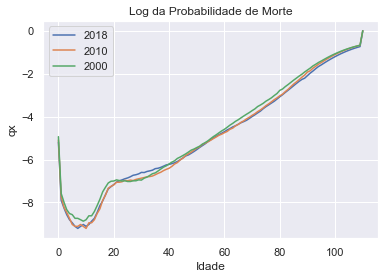

In [11]:
# Gráfico de log(mx{x,t})
fig, ax = plt.subplots()
ax.plot(df_dados2018['Age'], np.log(df_dados2018['qx']), label='2018')
ax.plot(df_dados2010['Age'], np.log(df_dados2010['qx']), label='2010')
ax.plot(df_dados2000['Age'], np.log(df_dados2000['qx']), label='2000')
#ax.plot('idade', np.log('mx'), data=df_dados2000)
#plt.plot('idade', 'lx', data=df_dados2018)
plt.title("Log da Probabilidade de Morte")
plt.xlabel('Idade')
plt.ylabel('qx')
plt.legend()
plt.show()

In [12]:
# O maior range de idade. Já foi tratado na preparação de dados. Importante a série anual ter o mesmo tamanho
w_max = max(df_dados['Age'])
#w = df_dados.groupby('ano').max()
primeiro_ano = 1933 
ultimo_ano = 2019
print(w_max)

110


In [13]:
# Verificar a primeira coorte anual. Feature qx.Estou mantendo a nomenclatura como mx para compatibilidade com a formulação, mas os valores são dos qx de cada idade para o primeiro ano.
mx = df_dados[df_dados['Year'] == primeiro_ano].values[:,3].reshape(w_max+1, 1)
pd.DataFrame(mx)

,0
0,0.05861
1,0.00941
2,0.00434
3,0.00310
4,0.00238
...,...
106,0.41433
107,0.42669
108,0.43878
109,0.45057


In [14]:
#Reshape o arquivo horizontalmente.
# Observar que o primeiro valor do range, considrar ano+1, porque a primeira coorte foi atribuída anteriormente.
# Se for executar este bloco, executar a célula anterior
for i in np.arange(primeiro_ano+1,ultimo_ano+1):
    mx = np.hstack([mx, df_dados[df_dados['Year'] == i].values[:,3].reshape(w_max+1,1)])

# O eixo também é armazenado na lista
idade=[x for x in range(w_max+1)]
ano=[x for x in range(primeiro_ano,ultimo_ano+1,1)]

In [15]:
pd.DataFrame(mx)

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,0.05861,0.06526,0.05881,0.05998,0.05859,0.05541,0.05127,0.05159,0.05031,0.04655,...,0.00618,0.00603,0.00598,0.00592,0.00583,0.00587,0.00583,0.00571,0.00558,0.00554
1,0.00941,0.01050,0.00887,0.00879,0.00833,0.00780,0.00628,0.00569,0.00550,0.00455,...,0.00043,0.00042,0.00041,0.00042,0.00037,0.00040,0.00039,0.00038,0.00037,0.00039
2,0.00434,0.00484,0.00414,0.00423,0.00396,0.00356,0.00290,0.00270,0.00257,0.00220,...,0.00027,0.00027,0.00027,0.00026,0.00025,0.00025,0.00026,0.00025,0.00026,0.00023
3,0.00310,0.00322,0.00298,0.00285,0.00270,0.00244,0.00209,0.00180,0.00178,0.00167,...,0.00021,0.00020,0.00020,0.00019,0.00019,0.00020,0.00020,0.00019,0.00019,0.00018
4,0.00238,0.00245,0.00240,0.00227,0.00214,0.00193,0.00168,0.00148,0.00141,0.00134,...,0.00016,0.00016,0.00017,0.00016,0.00016,0.00015,0.00016,0.00015,0.00015,0.00014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.41433,0.42164,0.43129,0.46331,0.44471,0.42225,0.44088,0.45785,0.43648,0.42635,...,0.45526,0.45740,0.45399,0.45170,0.44197,0.44540,0.43253,0.43198,0.42261,0.40742
107,0.42669,0.43408,0.44412,0.47591,0.45746,0.43508,0.45379,0.47069,0.44939,0.43942,...,0.47380,0.47600,0.47268,0.47049,0.46094,0.46436,0.45167,0.45117,0.44187,0.42668
108,0.43878,0.44622,0.45661,0.48804,0.46982,0.44758,0.46630,0.48307,0.46192,0.45215,...,0.49138,0.49360,0.49041,0.48833,0.47904,0.48241,0.47000,0.46955,0.46040,0.44533
109,0.45057,0.45804,0.46872,0.49968,0.48175,0.45974,0.47840,0.49496,0.47404,0.46451,...,0.50792,0.51014,0.50710,0.50513,0.49617,0.49946,0.48743,0.48702,0.47810,0.46327


In [16]:
# log(mx)É uma matriz de idade x ano de observação
logmx=np.log(mx)
pd.DataFrame(logmx)

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,-2.836850,-2.729376,-2.833443,-2.813744,-2.837191,-2.892995,-2.970649,-2.964427,-2.989551,-3.067228,...,-5.086437,-5.111008,-5.119335,-5.129419,-5.144738,-5.137901,-5.144738,-5.165536,-5.188567,-5.195761
1,-4.665982,-4.556380,-4.725080,-4.734141,-4.787892,-4.853632,-5.070385,-5.169045,-5.203007,-5.392628,...,-7.751725,-7.775256,-7.799353,-7.775256,-7.902008,-7.824046,-7.849364,-7.875339,-7.902008,-7.849364
2,-5.439881,-5.330841,-5.487059,-5.465553,-5.531511,-5.637995,-5.843045,-5.914504,-5.963849,-6.119298,...,-8.217089,-8.217089,-8.217089,-8.254829,-8.294050,-8.294050,-8.254829,-8.294050,-8.254829,-8.377431
3,-5.776353,-5.738374,-5.815832,-5.860436,-5.914504,-6.015757,-6.170591,-6.319969,-6.331142,-6.394932,...,-8.468403,-8.517193,-8.517193,-8.568486,-8.568486,-8.517193,-8.517193,-8.568486,-8.568486,-8.622554
4,-6.040655,-6.011667,-6.032287,-6.087975,-6.146949,-6.250235,-6.388961,-6.515713,-6.564166,-6.615086,...,-8.740337,-8.740337,-8.679712,-8.740337,-8.740337,-8.804875,-8.740337,-8.804875,-8.804875,-8.873868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,-0.881093,-0.863603,-0.840975,-0.769359,-0.810333,-0.862158,-0.818983,-0.781214,-0.829013,-0.852495,...,-0.786887,-0.782197,-0.789680,-0.794737,-0.816513,-0.808783,-0.838104,-0.839376,-0.861306,-0.897911
107,-0.851698,-0.834526,-0.811660,-0.742527,-0.782066,-0.832225,-0.790121,-0.753556,-0.799864,-0.822300,...,-0.746970,-0.742337,-0.749337,-0.753981,-0.774487,-0.767095,-0.794803,-0.795911,-0.816740,-0.851721
108,-0.823757,-0.806943,-0.783926,-0.717358,-0.755406,-0.803900,-0.762926,-0.727594,-0.772364,-0.793741,...,-0.710538,-0.706030,-0.712514,-0.716764,-0.735971,-0.728961,-0.755023,-0.755980,-0.775660,-0.808940
109,-0.797242,-0.780799,-0.757750,-0.693787,-0.730330,-0.777094,-0.737308,-0.703278,-0.746464,-0.766772,...,-0.677431,-0.673070,-0.679047,-0.682939,-0.700837,-0.694228,-0.718609,-0.719450,-0.737935,-0.769445


#### Passo 2: Modelo Lee-Carter
##### Lee,  R.D.,  Carter,  L.R.  (1992).  Modelling  and  Forecasting  U.S.  Mortality.  Journal of the American Statistical Association 87, 659-671

2.1 - Formula: $ ln(m_{x,t}) = a_x + b_x*k_t + \epsilon_{x,t} \\ $ 
2.1.1 - Restrições:
$ \Sigma b_x=1\\
\Sigma k_x=0 $

Onde:
* $ m_{x,t} $: Corresponde a Taxa central de mortalidade para cada idade *x*; 
* $ a_x $: Nível médio das taxas de mortalidade no tempo para cada idade *x*; 
* $ b_x $: Padrão médio da mortalidade à idade *x* quando o nível geral da mortalidade $ k_t $ se altera; 
* $ k_t $: Índice de tendência temporal do nível de mortalidade geral; 
* $ \epsilon_{x,t} $: Erro aleatório do tipo ruído branco, inserido no modelo para cada idade *x* no tempo *t*.

2.2 - Estimadores

2.2.1 - Fórmula 1:
$ \hat\alpha_x = \frac{1}{h} \sum\limits_{t=t_1} ^{t_n} ln (m_{x,t}) \\ $
Sendo: $ h = t_n - t_1 $

2.2.2 - Fórmula 2:
$ \beta_x*k_t = ln(m_{x,t}) - \alpha_x + \epsilon_{x,t} $

##### A Fórmula 2, na forma matricial Z, onde será aplicada a SVD (Singular Value Decomposition).
$ Z = \begin{vmatrix}
ln(m_{0,1998})-\hat\alpha_0 & ln(m_{0,1999})-\hat\alpha_0 & ... & ln(m_{0,2018})-\hat\alpha_0\\
ln(m_{1,1998})-\hat\alpha_1 & ln(m_{1,1999})-\hat\alpha_1 & ... & ln(m_{1,2018})-\hat\alpha_1\\
. & . & .\\
. & . & .\\
ln(m_{116,1998})-\hat\alpha_{116} & ln(m_{116,1999})-\hat\alpha_{116} & ... & ln(m_{116,2018})-\hat\alpha_{116}\\
\end{vmatrix} $

#### 2.3 - Singular Value Decomposition - SVD

* Estima o valor de b(x) e k(t) com o uso do método Singular Value Decomposition (SVD).
* Este método permite a decomposição da matriz [z_xt] de m linhas por n colunas em 3 matrizes:
* a matrix U de m por m, a matriz V de n por n e a matriz diagonal S de m por n.
$ A = USV^T $

##### 2.3.1 - A fórmula 2, reescrita com base na matriz Z:
##### 2.3.2 - Fórmula 3:
$ \hat\beta_x = \frac {U_{x,1}}{\sum\limits_{x=x_0} ^{x_{\omega}} U_{x,1}} $
##### 2.3.3 - Fórmula 4: Estima a feature tempo. Baseado no modelo ARIMA. 
$ \hat\kappa_t = V_{t,1}S_{1,1}\sum\limits_{x=x_0} ^{x_{\omega}} U_{x,1} $

##### 2.3.4 - Parametros iniciais da Matriz

In [17]:
#Parametros iniciais da Matriz
T = (ultimo_ano - primeiro_ano) +1  # Intervalo de anos disponíveis no dataset (1933-20198)
N = w_max + 1 # Idade Máxima em cada ano
logm_xt = logmx + 0 

# Estimativa dos parâmetros:
a_x = logm_xt.sum(axis=1) / T # (FÓRMULA 1)
# Para obter os parÂmetros estimados de ^bx e ^kt, aplica-se a SVD na matriz Z = ln(m{x,t}) - ^ax
z_xt = logm_xt - a_x.reshape(N,1) # (FÓRMULA 2)

In [18]:
pd.DataFrame(a_x).head(2).append(pd.DataFrame(a_x).tail(7))

,0
0,-4.138424
1,-6.703305
104,-0.897883
105,-0.857257
106,-0.819307
107,-0.783965
108,-0.751143
109,-0.720745
110,0.000000


In [19]:
# pd.set_option("display.precision", 5)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [20]:
pd.DataFrame(z_xt).head(3).append(pd.DataFrame(z_xt).tail())

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,1.30157,1.40905,1.30498,1.32468,1.30123,1.24543,1.16777,1.17400,1.14887,1.07120,...,-0.94801,-0.97258,-0.98091,-0.99099,-1.00631,-0.99948,-1.00631,-1.02711,-1.05014,-1.05734
1,2.03732,2.14693,1.97822,1.96916,1.91541,1.84967,1.63292,1.53426,1.50030,1.31068,...,-1.04842,-1.07195,-1.09605,-1.07195,-1.19870,-1.12074,-1.14606,-1.17203,-1.19870,-1.14606
2,1.74981,1.85885,1.70263,1.72414,1.65818,1.55170,1.34665,1.27519,1.22584,1.07039,...,-1.02740,-1.02740,-1.02740,-1.06514,-1.10436,-1.10436,-1.06514,-1.10436,-1.06514,-1.18774
106,-0.06179,-0.04430,-0.02167,0.04995,0.00897,-0.04285,0.00032,0.03809,-0.00971,-0.03319,...,0.03242,0.03711,0.02963,0.02457,0.00279,0.01052,-0.01880,-0.02007,-0.04200,-0.07860
107,-0.06773,-0.05056,-0.02770,0.04144,0.00190,-0.04826,-0.00616,0.03041,-0.01590,-0.03833,...,0.03700,0.04163,0.03463,0.02998,0.00948,0.01687,-0.01084,-0.01195,-0.03277,-0.06776
108,-0.07261,-0.05580,-0.03278,0.03379,-0.00426,-0.05276,-0.01178,0.02355,-0.02122,-0.04260,...,0.04061,0.04511,0.03863,0.03438,0.01517,0.02218,-0.00388,-0.00484,-0.02452,-0.05780
109,-0.07650,-0.06005,-0.03701,0.02696,-0.00959,-0.05635,-0.01656,0.01747,-0.02572,-0.04603,...,0.04331,0.04767,0.04170,0.03781,0.01991,0.02652,0.00214,0.00129,-0.01719,-0.04870
110,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [21]:
pd.reset_option('display.float_format')

In [22]:
# O modelo Lee-Carter é simples por utilizar a estimativa dos parâmetros pelo SVD
U, S, V = np.linalg.svd(z_xt, full_matrices=True)

bxkt = S[0] * np.dot(U[:,0].reshape(N,1),V[0,:].reshape(T,1).T) #
eps = z_xt - bxkt

# Modelo Lee-Carter
logm_xt_lcfitted = bxkt + a_x.reshape(N,1)

#bx,kx:
# Para estimar os parâmetros b(x) and k(t) , O Modelo Lee-Carter usa k=rank(Z).
# A estimativa do valor de b(x) pode ser obtido como o resultado da primeira coluna da matriz U
b_x = U[:,0]/U[:,0].sum() # (FÓRMULA 3)
# Para a estimativa do valor de k(t) é o resultado da multiplicação do primeiro valor singular
# e a primeira coluna da matriz V.
k_t = V[0,:]*S[0]*U[:,0].sum() # (FÓRMULA 4)

# Para estimar os valores a(x) e k(t):
a_x = a_x + k_t.sum()*b_x
k_t = k_t - k_t.sum()

In [23]:
# Formula 2.1.1
# A restrição foi observada somatório b_x -> 1
# A restrição foi observada somatório k_t -> 0

print('bx:', pd.DataFrame(b_x)[0].sum())
print()
print('kt:', np.around(pd.DataFrame(k_t)[0].sum(), decimals=10))

bx: 0.9999999999999999

kt: 1e-10


Optei por não agrupar as idades, usarei o qx.

##### 2.3.5 - Gráfico das componentes do modelo: ax, bx e kt

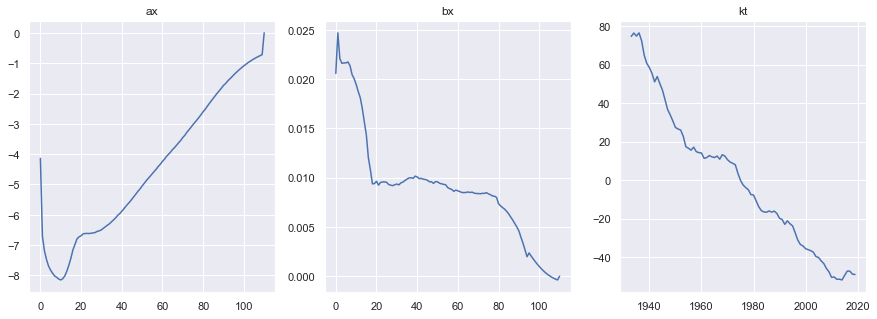

In [24]:
# Gráfico de ax,bx,kt.  
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(idade, a_x)
ax[0].set_title('ax')
ax[1].plot(idade, b_x)
ax[1].set_title('bx')
ax[2].plot(ano, k_t)
ax[2].set_title('kt')
plt.show()

##### 2.3.6 - Verificar convergencia do modelo 

In [25]:
#ax+bx*kt Confirmar se o valor previsto é convergente
chk = logm_xt_lcfitted - a_x.reshape(N,1)
chk = chk - np.dot(b_x.reshape(N,1),k_t.reshape(T,1).T)
chk = chk*chk
print(chk.sum())

1.0045946857309676e-27


##### Como a somatória dos valores tende a zero, o valor é convergente. Em resumo: $ a_x, b_x $ são estimadores para a feature idade e $ k_t $ é o estimador para a feature tempo. 

In [26]:
print(pd.DataFrame(a_x).shape)
print(pd.DataFrame(b_x).shape)
print(pd.DataFrame(k_t).shape)
print(pd.DataFrame(logm_xt_lcfitted).shape)

(111, 1)
(111, 1)
(87, 1)
(111, 87)


In [27]:
df_dados2018.head()

,Year,Age,mx,qx,ax,lx,dx,Lx,Tx,ex
9435,2018,0,0.00560,0.00558,0.14,100000,558,99519,7900914,79.01
9436,2018,1,0.00037,0.00037,0.50,99442,37,99424,7801394,78.45
9437,2018,2,0.00026,0.00026,0.50,99405,26,99392,7701970,77.48
9438,2018,3,0.00019,0.00019,0.50,99379,18,99370,7602578,76.50
9439,2018,4,0.00015,0.00015,0.50,99361,15,99354,7503208,75.51


#### Passo 3: Projeção da Mortalidade do Modelo Lee-Carter. Uso do modelo ARIMA

##### 3.1 - Preparar Dataset

In [28]:
# Preparar dataset
serie = {'t': ano, 'k_t': k_t}
df_tendencia = pd.DataFrame(serie, columns=['t','k_t'])
df_tendencia['t'] = pd.to_datetime(df_tendencia['t'], format='%Y')
df_tendencia.set_index('t', inplace=True)

In [29]:
df_tendencia.head() 

,k_t
t,
1933-01-01,74.633558
1934-01-01,76.374594
1935-01-01,74.791854
1936-01-01,76.472282
1937-01-01,72.325488


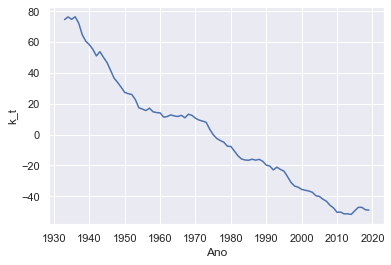

In [30]:
plt.xlabel('Ano')
plt.ylabel('k_t')
plt.plot(df_tendencia)


* 3.1.1 - Verificar se a série é estacionaria, antes de construir o modelo. Se for estacionaria, d=0
* 3.1.2 - Uma série é estacionária quando a média NÃO é função do tempo (não incrementa com o tempo)
* 3.1.3 - Uma série é estacionária quando a variancia NÃO é função do tempo. Esta propriedade é conhecida como homocedastidade.
* 3.1.4 -  Uma série é estacionária quando a covariancia NÃO é função do tempo
* 3.1.5 -  A stationary time series data is one whose properties do not depend on the time, That is why time series with trends, or with seasonality, are not stationary. 



#### 3.2 - Data Decomposition
* Decompor a feature alvo do dataset para verificar ou auxiliar na remoção da sazonalidade.
* A Decomposição tem 3 componentes, conforme o gráfico abaixo: Tendencia, sazonalidade e ruídos.
* O modelo aditivo foi escolhido porque a sazonalidade não varia ao longo do tempo. O outro modelo é o multiplicativo.

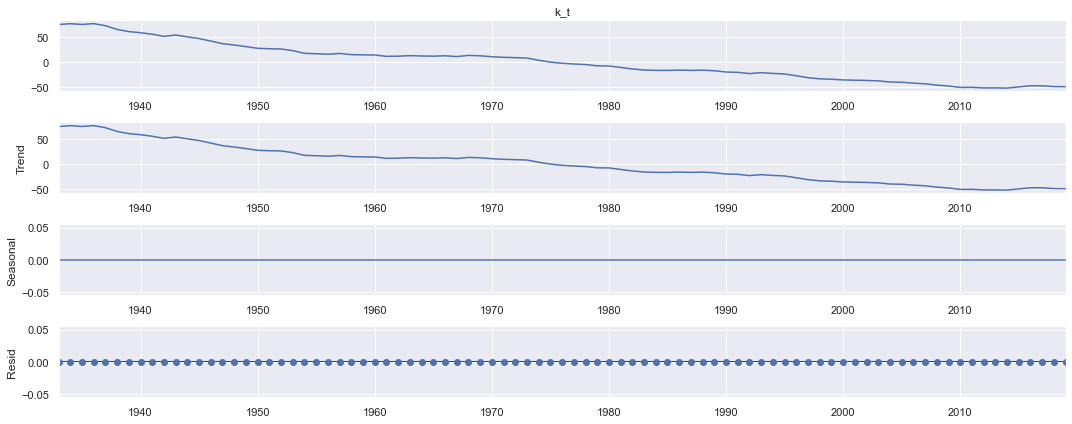

In [31]:
decomposition = sm.tsa.seasonal_decompose(df_tendencia.k_t, model='additive')
plt.rcParams["figure.figsize"] = [15,6]
fig = decomposition.plot()

* Graficamente, vemos que a série não tem sazonalidade ou ruído branco

#### 3.3 - Verificar a Estacionariedade

In [32]:
# First, I am going to check if the series is stationary using the Augmented Dickey Fuller test.
# You need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.
# if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed(de fato) stationary, ou seja, nossa série é estacionária: d<>0.
# Augmented Dickey-Fuller Test: The time series is considered stationary if the p-value # is low (according to the null hypothesis) and the critical values at 1%, 5%, 10% #confidence intervals are as close as possible to the ADF Statistics
#The ADF Statistic is far from the critical values and the p-value is greater than the threshold (0.05)
result = adfuller(k_t)
#print('ADF Statistic: %f' % result[0])
#print('p-value: %f' % result[1])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))
if result[1] < 0.05:
    print('A série é estacionária. p-value é ',  result[1])
else:
    print('A série não é estacionária, pois p-value é maior que 0.05 e ADF Statistic não é próximo dos Critical Values')

ADF Statistic: -2.8794489269259262
p-value: 0.04779053189631766
Critical Values:
	1%: -3.5097356063504983
	5%: -2.8961947486260944
	10%: -2.5852576124567475
A série é estacionária. p-value é  0.04779053189631766


#### Passo 4 — Seleção dos parâmetros para o modelo de Série Temporal ARIMA (Métrica: MSE)

In [33]:
# Instrução para gerar um grid do melhor ARIMA

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error


In [34]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order, mse))

                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [35]:
# Parâmetros p, d e q do ARIMA
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)

In [36]:
warnings.filterwarnings("ignore")
evaluate_models(df_tendencia.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=2496.363
ARIMA(0, 0, 1) MSE=642.796
ARIMA(0, 1, 0) MSE=2.601
ARIMA(0, 1, 1) MSE=2.364
ARIMA(0, 1, 2) MSE=2.121
ARIMA(0, 2, 0) MSE=3.077
ARIMA(0, 2, 1) MSE=2.349
ARIMA(0, 2, 2) MSE=2.160
ARIMA(1, 0, 0) MSE=3.295
ARIMA(1, 0, 1) MSE=2.849
ARIMA(1, 0, 2) MSE=2.196
ARIMA(1, 1, 0) MSE=2.222
ARIMA(1, 1, 1) MSE=2.162
ARIMA(1, 1, 2) MSE=2.147
ARIMA(1, 2, 0) MSE=2.369
ARIMA(1, 2, 1) MSE=2.083
ARIMA(1, 2, 2) MSE=2.057
ARIMA(2, 0, 0) MSE=2.364
ARIMA(2, 0, 1) MSE=2.278
ARIMA(2, 0, 2) MSE=2.237
ARIMA(2, 1, 0) MSE=2.126
ARIMA(2, 1, 1) MSE=2.142
ARIMA(2, 1, 2) MSE=2.422
ARIMA(2, 2, 0) MSE=2.691
ARIMA(2, 2, 1) MSE=2.036
ARIMA(2, 2, 2) MSE=2.337
ARIMA(4, 0, 0) MSE=2.409
ARIMA(4, 0, 1) MSE=2.577
ARIMA(4, 1, 0) MSE=2.188
ARIMA(4, 1, 1) MSE=2.296
ARIMA(4, 1, 2) MSE=2.354
ARIMA(4, 2, 0) MSE=2.392
ARIMA(4, 2, 1) MSE=2.081
ARIMA(4, 2, 2) MSE=2.454
ARIMA(6, 0, 0) MSE=2.318
ARIMA(6, 0, 1) MSE=2.391
ARIMA(6, 1, 0) MSE=2.216
ARIMA(6, 1, 1) MSE=2.292
ARIMA(6, 2, 0) MSE=2.378
ARIMA(6, 2, 1) MSE=2

* Calcular outras medidas para o melhor arima AIC (Akaike Information Criterion) e BIC (Bayesian Information Criterion)


#### Passo 4 — Seleção dos parâmetros para o modelo de Série Temporal ARIMA (Métrica: AIC)

In [37]:
arima_model = pm.auto_arima(df_tendencia, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=20,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      approx=False,
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False)

print(arima_model.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=359.482, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=355.507, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=354.817, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=356.582, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=353.613, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=354.585, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=356.395, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=358.307, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=354.389, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=356.359, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=358.344, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=360.287, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=356.367, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=358.348, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=360.279, Time=0.41 sec

Best model:  ARIMA(1,1,0

#### Passo 5 — Fitting a Série ARIMA

In [38]:
# fit model
model = ARIMA(df_tendencia, order=(1,1,0))
model_fit = model.fit(disp=0) # disp=0 (para desabilitar avisos)
print(model_fit.summary())  # print(model_fit.summary().tables[1]) 

                             ARIMA Model Results                              
Dep. Variable:                  D.k_t   No. Observations:                   86
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -173.807
Method:                       css-mle   S.D. of innovations              1.825
Date:                Sun, 22 Aug 2021   AIC                            353.613
Time:                        15:17:06   BIC                            360.976
Sample:                    01-01-1934   HQIC                           356.576
                         - 01-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.4148      0.280     -5.057      0.000      -1.963      -0.867
ar.L1.D.k_t     0.2995      0.104      2.875      0.004       0.095       0.504
                                    Roots       

#### Passo 6 — Previsão do Modelo

In [39]:
n=30
previsao,err,ci = model_fit.forecast(steps=n,alpha=0.05)

df_previsao = pd.DataFrame({'previsao':previsao},index=pd.date_range(start='1/1/2020',periods=n, freq='AS')) # Annual Start: AS (INICIA COM 01-01-YYYY). Somente A, o final 31-12-YYYY

In [40]:
ci

array([[ -53.53970109,  -46.3862484 ],
       [ -57.13342764,  -45.40347482],
       [ -60.33748951,  -44.96357018],
       [ -63.26127874,  -44.84982967],
       [ -65.98856976,  -44.94633394],
       [ -68.57458722,  -45.18822946],
       [ -71.05502999,  -45.53693311],
       [ -73.45352324,  -45.96795576],
       [ -75.78629151,  -46.46481405],
       [ -78.06491563,  -47.01584964],
       [ -80.29795902,  -47.6124759 ],
       [ -82.49195035,  -48.2481572 ],
       [ -84.65199723,  -48.91778383],
       [ -86.78218332,  -49.61727152],
       [ -88.88583401,  -50.34329469],
       [ -90.96569989,  -51.09310269],
       [ -93.02408686,  -51.86438961],
       [ -95.06295071,  -52.65519965],
       [ -97.08396727,  -53.46385699],
       [ -99.08858552,  -54.28891262],
       [-101.07806841,  -55.12910364],
       [-103.0535246 ,  -55.98332134],
       [-105.01593369,  -56.85058613],
       [-106.96616633,  -57.7300274 ],
       [-108.90500039,  -58.62086723],
       [-110.83313432,  -

In [41]:
df_previsao.head(10)

,previsao
2020-01-01,-49.962975
2021-01-01,-51.268451
2022-01-01,-52.650530
2023-01-01,-54.055554
2024-01-01,-55.467452
2025-01-01,-56.881408
2026-01-01,-58.295982
2027-01-01,-59.710739
2028-01-01,-61.125553
2029-01-01,-62.540383


#### 6.1 - Previsão com Intervalo de Confiança de 95%

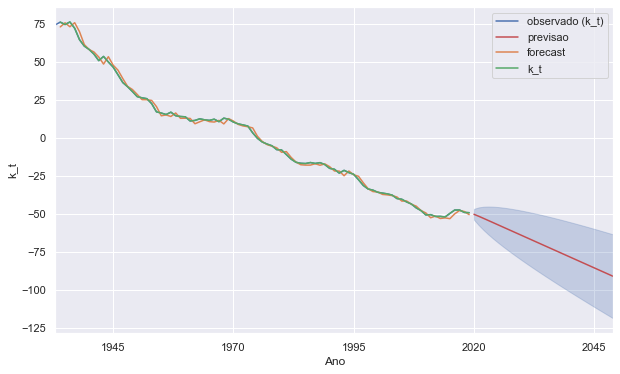

In [42]:
ax = df_tendencia[0:].k_t.plot(label='observado (k_t)', figsize=(10, 6))
df_previsao.plot(ax=ax, color='r')
model_fit.plot_predict(ax=ax, dynamic=False)
ax.fill_between(df_previsao.index,
                ci[:,0],
                ci[:,1],               
                color='b', alpha=.25)
ax.set_xlabel('Ano')
ax.set_ylabel('k_t')
#plt.legend()
plt.show()

In [ ]:
Tentar juntar o grafico abaixo com o de cima

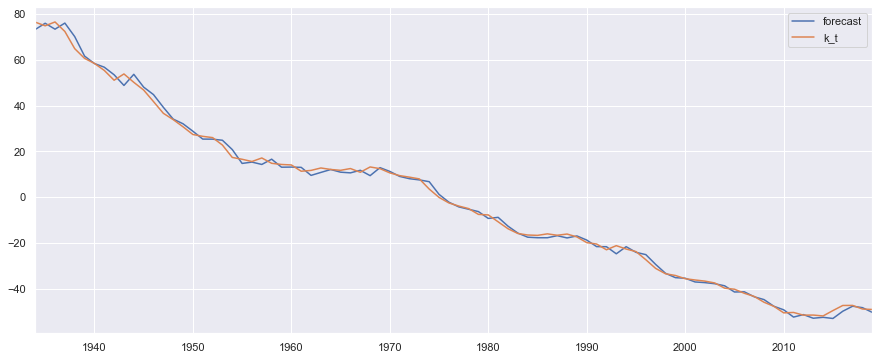

In [43]:
# Actual vs Fitted
# When you set dynamic=False the in-sample lagged values are used for prediction.
model_fit.plot_predict(dynamic=False)
plt.show()

#### Passo 7: Construir a tábua de qx a partir dos valores de $ k_t $ previstos.

In [44]:
df_previsao.head().append(df_previsao.tail())

,previsao
2020-01-01,-49.962975
2021-01-01,-51.268451
2022-01-01,-52.650530
2023-01-01,-54.055554
2024-01-01,-55.467452
2045-01-01,-85.177771
2046-01-01,-86.592608
2047-01-01,-88.007445
2048-01-01,-89.422282
2049-01-01,-90.837119


In [45]:
print(pd.DataFrame(a_x).shape)
print(pd.DataFrame(b_x).shape)
print(df_previsao.shape)

(111, 1)
(111, 1)
(30, 1)


In [46]:
kt = df_previsao['previsao'].values

In [47]:
kt

array([-49.96297474, -51.26845123, -52.65052984, -54.05555421,
       -55.46745185, -56.88140834, -58.29598155, -59.7107395 ,
       -61.12555278, -62.54038264, -63.95521746, -65.37005377,
       -66.78489053, -68.19972742, -69.61456435, -71.02940129,
       -72.44423824, -73.85907518, -75.27391213, -76.68874907,
       -78.10358602, -79.51842297, -80.93325991, -82.34809686,
       -83.76293381, -85.17777076, -86.5926077 , -88.00744465,
       -89.4222816 , -90.83711854])

In [48]:
len(kt)

30

In [49]:
pd.DataFrame(kt.reshape(len(kt),1).T)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-49.962975,-51.268451,-52.65053,-54.055554,-55.467452,-56.881408,-58.295982,-59.710739,-61.125553,-62.540383,...,-78.103586,-79.518423,-80.93326,-82.348097,-83.762934,-85.177771,-86.592608,-88.007445,-89.422282,-90.837119


In [50]:
np.exp(a_x.reshape(len(a_x), 1) + b_x.reshape(len(b_x), 1)*kt.reshape(len(kt), 1).T)

array([[5.70180543e-03, 5.55061125e-03, 5.39491207e-03, ...,
        2.60541380e-03, 2.53062266e-03, 2.45797848e-03],
       [3.56997736e-04, 3.45666339e-04, 3.34061741e-04, ...,
        1.39453858e-04, 1.34663120e-04, 1.30036961e-04],
       [2.50306004e-04, 2.43194240e-04, 2.35885246e-04, ...,
        1.08061149e-04, 1.04737682e-04, 1.01516431e-04],
       ...,
       [4.78851363e-01, 4.79036300e-01, 4.79232167e-01, ...,
        4.84270229e-01, 4.84472929e-01, 4.84675715e-01],
       [4.95673257e-01, 4.95918181e-01, 4.96177608e-01, ...,
        5.02860728e-01, 5.03130024e-01, 5.03399464e-01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [51]:
# anos do intervalo da previsão
ano_inicio = df_previsao.index.year[0]
anos = np.arange(ano_inicio, ano_inicio+len(kt))
anos


array([2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,
       2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041,
       2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049], dtype=int64)

In [52]:
df_qxleecarter = pd.DataFrame(np.exp(a_x.reshape(len(a_x), 1) + b_x.reshape(len(b_x), 1)*kt.reshape(len(kt), 1).T), columns=anos)

<AxesSubplot:>

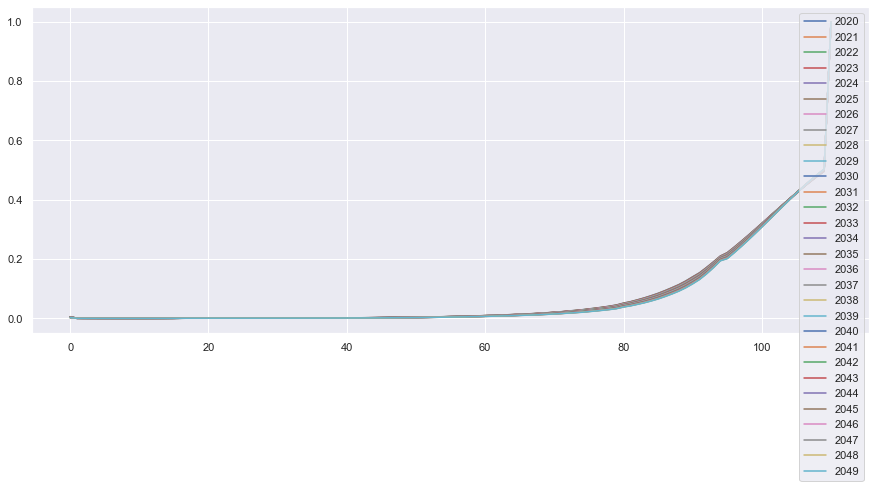

In [53]:
# ln(qx) = a_x + b_x *k_t
pd.DataFrame(df_qxleecarter).plot()

In [54]:
df_qxleecarter.head()

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,...,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049
0,0.005702,0.005551,0.005395,0.005241,0.005091,0.004945,0.004803,0.004665,0.004531,0.004401,...,0.003195,0.003103,0.003014,0.002927,0.002843,0.002762,0.002682,0.002605,0.002531,0.002458
1,0.000357,0.000346,0.000334,0.000323,0.000312,0.000301,0.000291,0.000281,0.000271,0.000262,...,0.000178,0.000172,0.000166,0.000160,0.000155,0.000150,0.000144,0.000139,0.000135,0.000130
2,0.000250,0.000243,0.000236,0.000229,0.000222,0.000215,0.000208,0.000202,0.000196,0.000190,...,0.000134,0.000130,0.000126,0.000122,0.000119,0.000115,0.000111,0.000108,0.000105,0.000102
3,0.000193,0.000187,0.000182,0.000176,0.000171,0.000166,0.000161,0.000156,0.000151,0.000147,...,0.000105,0.000102,0.000099,0.000096,0.000093,0.000090,0.000087,0.000085,0.000082,0.000080
4,0.000155,0.000151,0.000147,0.000142,0.000138,0.000134,0.000130,0.000126,0.000122,0.000118,...,0.000084,0.000082,0.000079,0.000077,0.000075,0.000072,0.000070,0.000068,0.000066,0.000064


#### Passo 8: Exportar os resultados

In [55]:
df_previsao.to_csv(pasta_resultados + '/' + 'kt_previsao_demography.csv')

In [56]:
df_qxleecarter.to_csv(pasta_resultados + '/' + 'leecarter_previsao_demography.csv')

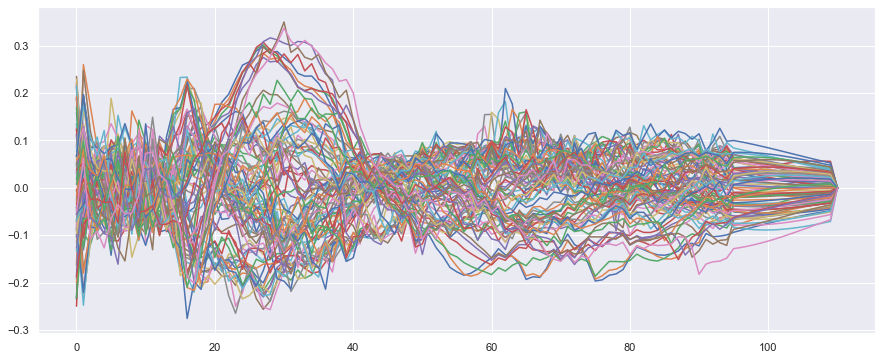

In [57]:

plt.plot(pd.DataFrame(eps))